# **Save this file as studentid1_studentid2_lab2.ipynb**, please check this suffix when you upload your lab, especially when you have multiple copy's in the same folder!
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab2.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). Note, that **you are not allowed to use Google Colab**.

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [1]:
NAME = "Victor Zuanazzi"
NAME2 = "David Speck"
NAME3 = ""
EMAIL = "victorzuanazzi@gmail.com"
EMAIL2 = "david.speck@saduras.de"
EMAIL3 = ""

# Lab 2: Classification

### Machine Learning 1, November 2018

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Use the provided test cells to check if your answers are correct
* **Make sure your output and plots are correct before handing in your assignment with Kernel -> Restart & Run All**

* **If possible, all your implementations should be vectorized and rely on loops as little as possible. Therefore for some questions, we give you a maximum number of loops that are necessary for an efficient implementation. This number refers to the loops in this particular function and does not count the ones in functions that are called from the function. You should not go above this number for the maximum number of points.**

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [9,5]

import time
start = time.time()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# This cell makes sure that you have all the necessary libraries installed

import sys
import platform
from importlib.util import find_spec, module_from_spec

def check_newer_version(version_inst, version_nec):
    version_inst_split = version_inst.split('.')
    version_nec_split = version_nec.split('.')
    for i in range(min(len(version_inst_split), len(version_nec_split))):
        if int(version_nec_split[i]) > int(version_inst_split[i]):
            return False
        elif int(version_nec_split[i]) < int(version_inst_split[i]):
            return True
    return True
        
    
module_list = [('jupyter', '1.0.0'), 
               ('matplotlib', '2.0.2'), 
               ('numpy', '1.13.1'), 
               ('python', '3.6.2'), 
               ('sklearn', '0.19.0'), 
               ('scipy', '0.19.1'), 
               ('nb_conda', '2.2.1')]

packages_correct = True
packages_errors = []

for module_name, version in module_list:
    if module_name == 'scikit-learn':
        module_name = 'sklearn'
    if module_name == 'pyyaml':
        module_name = 'yaml'
    if 'python' in module_name:
        python_version = platform.python_version()
        if not check_newer_version(python_version, version):
            packages_correct = False
            error = f'Update {module_name} to version {version}. Current version is {python_version}.'
            packages_errors.append(error) 
            print(error)
    else:
        spec = find_spec(module_name)
        if spec is None:
            packages_correct = False
            error = f'Install {module_name} with version {version} or newer, it is required for this assignment!'
            packages_errors.append(error) 
            print(error)
        else:
            x =__import__(module_name)
            if hasattr(x, '__version__') and not check_newer_version(x.__version__, version):
                packages_correct = False
                error = f'Update {module_name} to version {version}. Current version is {x.__version__}.'
                packages_errors.append(error) 
                print(error)

try:
    from google.colab import drive
    packages_correct = False
    error = """Please, don't use google colab!
It will make it much more complicated for us to check your homework as it merges all the cells into one."""
    packages_errors.append(error) 
    print(error)
except:
    pass

packages_errors = '\n'.join(packages_errors)

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can download the data with scikit learn, and load it as follows:

In [4]:
from sklearn.datasets import fetch_mldata
import os
# Fetch the data
try:
    mnist = fetch_mldata('MNIST original', data_home='.')
except Exception:
    raise FileNotFoundError('Please download mnist-original.mat from Canvas and put it in %s/mldata' % os.getcwd())
data, target = mnist.data, mnist.target.astype('int')
# Shuffle
indices = np.arange(len(data))
np.random.seed(123)
np.random.shuffle(indices)
data, target = data[indices].astype('float32'), target[indices]

# Normalize the data between 0.0 and 1.0:
data /= 255. 

# Split
x_train, x_valid, x_test = data[:50000], data[50000:60000], data[60000: 70000]
t_train, t_valid, t_test = target[:50000], target[50000:60000], target[60000: 70000]

MNIST consists of small 28 by 28 pixel images of written digits (0-9). We split the dataset into a training, validation and testing arrays. The variables `x_train`, `x_valid` and `x_test` are $N \times M$ matrices, where $N$ is the number of datapoints in the respective set, and $M = 28^2 = 784$ is the dimensionality of the data. The second set of variables `t_train`, `t_valid` and `t_test` contain the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

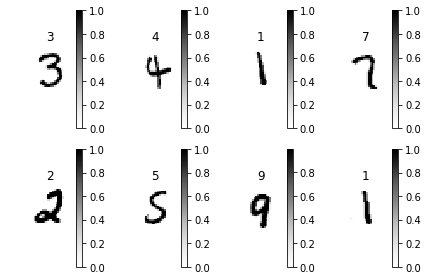

In [5]:
def plot_digits(data, num_cols, targets=None, shape=(28,28)):
    num_digits = data.shape[0]
    num_rows = int(num_digits/num_cols)
    for i in range(num_digits):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(data[i].reshape(shape), interpolation='none', cmap='Greys')
        if targets is not None:
            plt.title(int(targets[i]))
        plt.colorbar()
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_digits(x_train[0:40000:5000], num_cols=4, targets=t_train[0:40000:5000])

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_i \exp(\log q_i)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

**Warning**: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://www.xarg.org/2016/06/the-log-sum-exp-trick-in-machine-learning/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization
### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
$$

For $j \neq t^{(n)}$:
$$
\delta^q_j
= \frac{\partial \log q_{t^{(n)}}}{\partial \log q_j}
-
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
=0 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.



For $j = t^{(n)}$:
\begin{align}
\delta^q_j
&= 1- \frac{exp(log(q_j))}{Z} = 1 - \frac{q_j}{Z}
\end{align}
For $j \neq t^{(n)}$:
\begin{align}
\delta^q_j
&= - \frac{exp(log(q_j))}{Z} = - \frac{q_j}{Z}
\end{align}
The general case is:
\begin{align}
\delta^q_j
&= \mathcal{I}(j = t^{(n)}) - \frac{q_i}{Z}
\end{align}

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}} = \mathbf{\delta}_j^q x_i
\Rightarrow \frac{\mathcal{L}^{(n)}}{\partial W} =  \mathbf{x}(\delta^q)^T
$

### 1.1.2 Implement gradient computations (15 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).

For maximum points, ensure the function is numerically stable.


In [6]:
# 1.1.2 Compute gradient of log p(t|x;w,b) wrt w and b
# for numerical stability : https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.misc.logsumexp.html
from scipy.special import logsumexp 
import numpy as np

def one_hot(a, num_classes):
    return np.eye(num_classes)[a.reshape(-1)]

def logprob(x, w, b):
    ln_q = np.matmul(x, w) + b     
    ln_Z = logsumexp(ln_q)     
   
    ln_p = ln_q - ln_Z
    return ln_q, ln_Z, ln_p   

def logreg_gradient(x, t, w, b):
    num_classes = len(b)
    
    ln_q, ln_Z, ln_p = logprob(x, w, b)
    t_oh = one_hot(t, num_classes)
    
    delta = t_oh - np.exp(ln_q)/np.exp(ln_Z)   #
    
    dL_db = delta
    dL_dw = np.matmul(x.T, delta)
    logp = ln_p
    
    # here the statement contains logp[:,t] where logp is meant as a matrix of shape 1x10
    return logp[:,t].squeeze(), dL_dw, dL_db.squeeze()

In [7]:
# Hidden tests for efficiency

In [8]:
np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

# test gradients, train on 1 sample
logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)

print("Test gradient on one point")
print("Log Likelihood:\t", logpt)
print("\nGrad_W_ij\t",grad_w.shape,"matrix")
print("Grad_W_ij[0,152:158]=\t", grad_w[152:158,0])
print("\nGrad_B_i shape\t",grad_b.shape,"vector")
print("Grad_B_i=\t", grad_b.T)
print("i in {0,...,9}; j in M")

assert logpt.shape == (), logpt.shape
assert grad_w.shape == (784, 10), grad_w.shape
assert grad_b.shape == (10,), grad_b.shape




Test gradient on one point
Log Likelihood:	 -2.2959726720744777

Grad_W_ij	 (784, 10) matrix
Grad_W_ij[0,152:158]=	 [-0.04518971 -0.06758809 -0.07819784 -0.09077237 -0.07584012 -0.06365855]

Grad_B_i shape	 (10,) vector
Grad_B_i=	 [-0.10020327 -0.09977827 -0.1003198   0.89933657 -0.10037941 -0.10072863
 -0.09982729 -0.09928672 -0.09949324 -0.09931994]
i in {0,...,9}; j in M


In [9]:
# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
w = np.random.normal(size=(28*28,10), scale=0.001)
# w = np.zeros((784,10))
b = np.zeros((10,))

def func(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return logpt
def grad(w):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w.reshape(784,10), b)
    return grad_w.flatten()
finite_diff_error = check_grad(func, grad, w.flatten())
print('Finite difference error grad_w:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for w seems off'

def func(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return logpt
def grad(b):
    logpt, grad_w, grad_b = logreg_gradient(x_train[0:1,:], t_train[0:1], w, b)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'



Finite difference error grad_w: 6.3612946893e-07
Finite difference error grad_b: 5.23511748609e-08


In [10]:
# DO NOT REMOVE THIS CELL!
# It contains hidden tests



### 1.1.3 Stochastic gradient descent (15 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters **using a small learning rate of `1e-6`**. Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [11]:
def sgd_iter(x_train, t_train, W, b):
    
    #every day I am shufflin`
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    lr = 1e-4
    
    logp = np.zeros(len(x_train))
    for i in indices:
        x = x_train[i:i+1]
        t = t_train[i]
        logp[i], grad_w, grad_b = logreg_gradient(x, t, W, b)
        W = W + lr*grad_w #grad ascent
        b = b + lr*grad_b
    
    logp_train = logp.mean()
    return logp_train, W, b

In [12]:
# Hidden tests for efficiency

In [13]:
# Sanity check:
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
    
logp_train, W, b = sgd_iter(x_train[:5], t_train[:5], w, b)




## 1.2. Train

### 1.2.1 Train (12 points)
Perform SGD on the training set. Plot (in one graph) the conditional log-probability of the training set and validation set after each iteration. (6 points)

Instead of running SGD for a fixed number of steps, run it until convergence. Think of a reasonable criterion for determining convergence. As a reference: choose a criterion such that the algorithm terminates in less than 15 iterations over the training set. (2 points)

Make sure your implementation (in particular, the output of the conditional log-probability of the training set and validation set) is independent of the size of the dataset. (2 points)

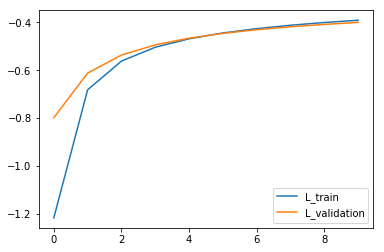

In [14]:
def test_sgd(x_train, t_train, x_valid, t_valid, w, b):
    Lts = []
    Lvs = []
    epsilon = 1e-2
    while (len(Lts) < 2 or abs(Lts[-1] - Lts[-2]) > epsilon) and len(Lts) < 25:
        L_train, w, b = sgd_iter(x_train, t_train, w, b)
        
        logp = []
        for x, t in zip(x_valid, t_valid):
            _, _, logp_valid = logprob(x, w, b)
            logp.append(logp_valid[t])

        L_valid = np.array(logp).mean()
        
        Lts.append(L_train)
        Lvs.append(L_valid)
        
    x = np.arange(len(Lts))
    plt.plot(x, Lts, label = "L_train")
    plt.plot(x, Lvs, label = "L_validation")
    plt.legend()
    plt.show()
    
    return w, b
        
np.random.seed(1243)
w = np.zeros((28*28, 10))
b = np.zeros(10)
w,b = test_sgd(x_train, t_train, x_valid, t_valid, w, b)

In [15]:
# Hidden tests for efficiency

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.


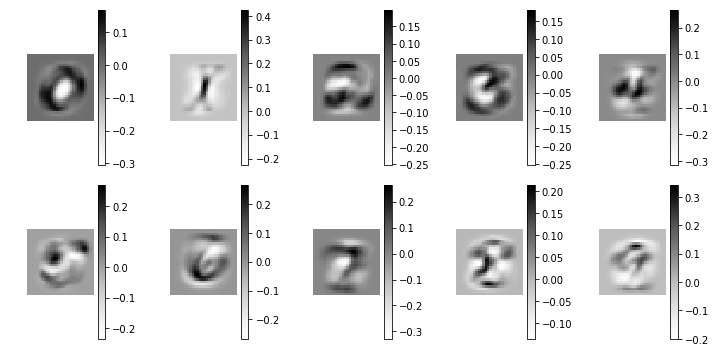

In [16]:
plt.figure(figsize=(10,5))
plot_digits(w.T, num_cols=5)

**Describe in less than 100 words why these weights minimize the loss**

The weights are the highest in the pixels that carry relevant information for features of the class. Complementarily, the weights became negative for the pixels that carry relevant information for features not present in the class. This minimizes the loss because the weights are trying to form the same patents that present in the numbers.

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.


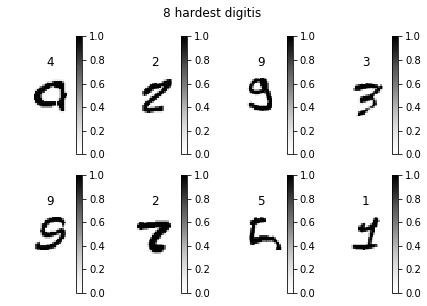

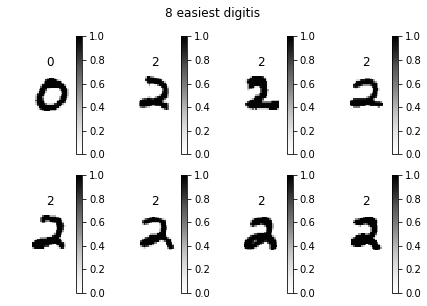

In [17]:
logp = []
for x, t in zip(x_valid, t_valid):
    _, _, logp_valid = logprob(x, w, b)
    logp.append(logp_valid[t])

data = list(zip(logp, x_valid, t_valid))
data.sort(key=lambda tup: tup[0])

# hardest 8 digits
xs = np.array([d[1] for d in data[:8]])
ts = np.array([d[2] for d in data[:8]])

plt.suptitle('8 hardest digitis', y = 1.05)
plot_digits(xs, num_cols=4, targets=ts)

# easiest 8 digits
xs = np.array([d[1] for d in data[-8:]])
ts = np.array([d[2] for d in data[-8:]])

plt.suptitle('8 easiest digitis', y = 1.05)
plot_digits(xs, num_cols=4, targets=ts)

Ask yourself if these results make sense. Explain in no more then two sentences what it means that a digit is hard to classify.

Yes, the results make sense. A handwritten digit is hard to classify if the primary features of the the digit are only weakly present and there is a big resemblance with other potential digits. For example the miss-classified 4 looks almost like a 0.

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron will have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$).

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

**Answer**:
$\bh$ does not depent on $\bb$ so we get just like for multiclass logisitc regression:
$$
    \nabla_{\bb_j} \mathcal{L}^{(n)} = \sum_k \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} \frac{\partial \log q_k}{\partial \bb_j} = \sum_k \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} \mathcal{I}_{(j=k)} = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j} = \delta^q_j
$$
With that we get $\nabla_{\bb} \mathcal{L}^{(n)} = \delta^q$.

For $\nabla_{\bw_j} \mathcal{L}^{(n)}$ we get this time:
$$
    \nabla_{\bw_j} \mathcal{L}^{(n)} = \sum_k \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_k} \frac{\partial \log q_k}{\partial \bw_j}
$$
Where
$$
    \frac{\partial \log q_k}{\partial \bW_{ij}} = \frac{\partial}{\partial \bW_{ij}} \bw_k^T\bh + \bb_k = \mathcal{I}_{(j=k)} \bh_i
$$
It follows:
$$
    \nabla_{\bw_j} \mathcal{L}^{(n)} = \delta_j^q \bh^T
$$
As matrix form:
$$
    \nabla_{\bW} \mathcal{L}^{(n)} = \bh (\delta^q)^T
$$
This is similar to the result from the multiclass logistic regression just $\bh$ in the role of $\bx$.

Derivative with resprect to $a$:
$$
    \nabla_{\ba} \mathcal{L}^{(n)} = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh} \frac{\partial \bh}{\partial \ba} = \delta^\bh \frac{\partial \bh}{\partial \ba}
$$
$$
    \frac{\partial \bh_i}{\partial \ba_j} = \frac{\partial}{\partial \ba_j} \sigma(\bv_i^T\bx + \ba_i) = \mathcal{I}_{(i=j)} \sigma(\bv_j^T\bx + \ba_j) (1 - \sigma(\bv_j^T\bx + \ba_j)) = \mathcal{I}_{(i=j)} \bh_j(1 - \bh_j)
$$
$$
    \nabla_{\ba_j} \mathcal{L}^{(n)} = \sum_i \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_i} \frac{\partial \bh_i}{\partial \ba_j} = \sum_i \delta_i^\bh \mathcal{I}_{(i=j)} \bh_j(1 - \bh_j) = \delta_j^\bh \bh_j(1 - \bh_j)
$$

Derivative with resprect to $V$:
$$
  \frac{\partial \bh_i}{\partial \bv_j} = \frac{\partial}{\partial \bv_j} \sigma(\bv_i^T\bx + \ba_i) = \mathcal{I}_{(i=j)} \sigma(\bv_j^T\bx + \ba_j) (1 - \sigma(\bv_j^T\bx + \ba_j)) \bx^T = \mathcal{I}_{(i=j)} \bh_j(1 - \bh_j) x^T
$$
$$
    \nabla_{\bv_j} \mathcal{L}^{(n)} = \sum_i \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_i} \frac{\partial \bh_i}{\partial \bv_j} = \delta_j^\bh \bh_j(1 - \bh_j) \bx^T = \nabla_{\ba_j} \mathcal{L}^{(n)} \bx^T
    \Rightarrow \nabla_{\bV} \mathcal{L}^{(n)} = \bx \nabla_{\ba} \mathcal{L}^{(n)}
$$

$\delta^\bh$:
$$
    \delta_j^\bh = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j} = \sum_i \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_i} \frac{\partial \log q_i}{\partial \bh_j} = \sum_i \delta_i^q \bw_{ji} = \delta^q \bw_j
$$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

For a generic parameter $\theta$, the MAP solution finds most probably $\theta$ given the data and a prior distribution of $\theta$. However, ML only give us information about the likelihood. By using the Bayes Theorem:
$$ \theta_{MAP} = argmax_\theta \log \left( p(\theta | D) \right) = argmax_\theta \left( \log \left( \frac{p(D | \theta) p(\theta)}{p(D)} \right)\right) $$
Which is solved into the following form:
$$ \theta_{MAP} = argmax_\theta \log  p(D | \theta) + \log p(\theta) $$

However, we are already calculating the gradient of $p(D | \theta)$ in when optmizing towards ML, if we add the gradient of the prior to it we can use our SGD algorithm to optimize towards the MAP solution of $\theta$.

## 2.3. Implement and train a MLP (15 points)

Implement an MLP model with a single hidden layer of **20 neurons**. 
Train the model for **10 epochs**.
Test your implementation for learning rates of 1e-2, 1e-3 and 1e-4 and plot (in one graph) the conditional log-probability of the trainingset and validation set. 

For the best model plot the weights of the first layer for in epoch 0,4 and 9. 


- 10 points: Working MLP that learns with plots
- +5 points: Fast, numerically stable, vectorized implementation

In [18]:
# Write all helper functions here
from scipy.special import logsumexp
from scipy.special import expit
import numpy as np

def one_hot(a, num_classes):
    return np.eye(num_classes)[a.reshape(-1)]

def mlp_logprob(x, W, b, V, a):
    h = expit(np.matmul(x, V) + a)
    
    ln_q = np.matmul(h, W) + b     
    ln_Z = logsumexp(ln_q)       
    ln_p = ln_q - ln_Z
    
    return ln_p, ln_q, ln_Z, h   

def mlp_gradient(x, t, W, b, V, a):
    num_classes = len(b)
    
    ln_p, ln_q, ln_Z, h = mlp_logprob(x, W, b, V, a)
    t_oh = one_hot(t, num_classes)
    
    delta_q = t_oh - np.exp(ln_q)/np.exp(ln_Z)
    delta_h = np.matmul(delta_q, W.T)
    
    dL_db = delta_q
    dL_dW = np.matmul(h.T, delta_q)
    dL_da = delta_h * h * (1 - h)
    dL_dV = np.matmul(x.T, dL_da)
    
    return ln_p[:,t].squeeze(), dL_dW, dL_db.squeeze(), dL_dV, dL_da.squeeze()

def init_params(input_size, num_classes, hidden_units):
    W = np.random.normal(size=(hidden_units, num_classes), scale=0.1)
    b = np.zeros(num_classes)
    V = np.random.normal(size=(input_size, hidden_units), scale=0.1)
    a = np.zeros(hidden_units)
    return W, b, V, a

def mlp_sgd_iter(x_train, t_train, W, b, V, a, lr):
    
    #every day I am shufflin`
    indices = np.arange(len(x_train))
    np.random.shuffle(indices)
    
    logp = np.zeros(len(x_train))
    for i in indices:
        x = x_train[i:i+1]
        t = t_train[i]
        logp[i], grad_W, grad_b, grad_V, grad_a = mlp_gradient(x, t, W, b, V, a)
        #grad ascent
        W = W + lr*grad_W 
        b = b + lr*grad_b
        V = V + lr*grad_V
        a = a + lr*grad_a
    
    logp_train = logp.mean()
    return logp_train, W, b, V, a

def eval_mean_logp(xs, ts, W, b, V, a):
    logps = []
    for x,t in zip(xs, ts):
        logp, _, _, _ = mlp_logprob(x, W, b, V, a)
        logps.append(logp[t].squeeze())
    return mean(logps)




# It's always good to check your gradient implementations with finite difference checking:
# Scipy provides the check_grad function, which requires flat input variables.
# So we write two helper functions that provide the gradient and output with 'flat' weights:
from scipy.optimize import check_grad

np.random.seed(123)
# scalar, 10 X 768  matrix, 10 X 1 vector
W = np.random.normal(size=(20,10), scale=0.001)
b = np.zeros((10,))
V = np.random.normal(size=(28*28, 20), scale=0.001)
a = np.zeros(20)

def func(w):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], w.reshape(20,10), b, V, a)
    return logpt
def grad(w):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], w.reshape(20,10), b, V, a)
    return grad_W.flatten()
finite_diff_error = check_grad(func, grad, W.flatten())
print('Finite difference error grad_W:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for W seems off'

def func(b):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], W, b, V, a)
    return logpt
def grad(b):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], W, b, V, a)
    return grad_b.flatten()
finite_diff_error = check_grad(func, grad, b)
print('Finite difference error grad_b:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for b seems off'

def func(v):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], W, b, v.reshape(28*28,20), a)
    return logpt
def grad(v):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], W, b, v.reshape(28*28,20), a)
    return grad_V.flatten()
finite_diff_error = check_grad(func, grad, V.flatten())
print('Finite difference error grad_V:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for V seems off'

def func(a):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], W, b, V, a)
    return logpt
def grad(a):
    logpt, grad_W, grad_b, grad_V, grad_a = mlp_gradient(x_train[0:1,:], t_train[0:1], W, b, V, a)
    return grad_a.flatten()
finite_diff_error = check_grad(func, grad, a.flatten())
print('Finite difference error grad_a:', finite_diff_error)
assert finite_diff_error < 1e-3, 'Your gradient computation for a seems off'



Finite difference error grad_W: 2.89451814261e-07
Finite difference error grad_b: 4.63029861055e-08
Finite difference error grad_V: 1.68529087049e-06
Finite difference error grad_a: 1.3503394167e-07


In [19]:
# Hidden tests for efficiency

In [20]:
# Write training code here:
# Plot the conditional loglikelihoods for the train and validation dataset after every epoch.
# Plot the weights of the first layer.

def mlp_test(x_train, t_train, x_valid, t_valid):
    epochs = 10
    lrs = [1e-2, 1e-3, 1e-4]

    Vs = [[],[],[]]
    logp_train = [[],[],[]]
    logp_valid = [[],[],[]]
    
    for i, lr in enumerate(lrs):
        W, b, V, a = init_params(28*28, 10, 20) 
        # Calculate log prob before training
        logp_t = eval_mean_logp(x_train, t_train, W, b, V, a)
        logp_v = eval_mean_logp(x_valid, t_valid, W, b, V, a)
        logp_train[i].append(logp_t)
        logp_valid[i].append(logp_v)
        Vs[i].append(V)
        
        print(f'lr: {lr}')
        for epoch in range(1,epochs+1):
            print(f'epoch: {epoch}', end='\r')
            logp_t, W, b, V, a = mlp_sgd_iter(x_train, t_train, W, b ,V, a, lr)
            logp_v = eval_mean_logp(x_valid, t_valid, W, b, V, a)
            
            Vs[i].append(V)
            logp_train[i].append(logp_t)
            logp_valid[i].append(logp_v)
            
    return logp_train, logp_valid, Vs 


logp_train, logp_valid, Vs = mlp_test(x_train, t_train, x_valid, t_valid)

lr: 0.01
lr: 0.001
lr: 0.0001


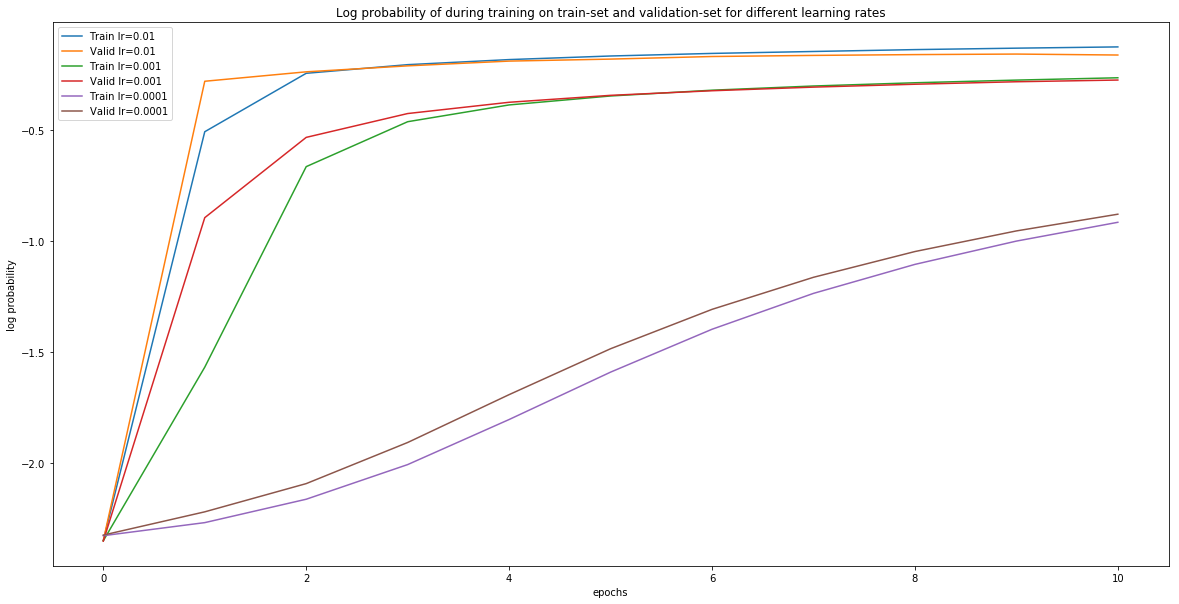

In [21]:
# plot the train and validation logp for all three learning rates in one figure
lrs = [1e-2, 1e-3, 1e-4]

plt.figure(figsize=(20,10))
for i in range(len(logp_train)):
    plt.plot(logp_train[i], label=f'Train lr={lrs[i]}')
    plt.plot(logp_valid[i], label=f'Valid lr={lrs[i]}')
plt.title('Log probability of during training on train-set and validation-set for different learning rates')
plt.xlabel('epochs')
plt.ylabel('log probability')
plt.legend()
plt.show()

### 2.3.1. Explain the learning curves (5 points)
In less than 80 words, explain the observed behaviour for the different learning rates.

The learning rate that converges the fastest is $1e-2$. The lower learning rates $1e-3$ and $1e-4$ need more time to converge, with $1e-4$ being the slowest. Which is expected, as a low learning rate implies in a smaller step towards the optmal optmal parameters. None of the learning rates seem to be too large to make the model diverge during training. 


### 2.3.2. Explain the weights (5 points)
In less than 80 words, explain how and why the weights of the hidden layer of the MLP differ from the logistic regression model, and relate this to the stronger performance of the MLP.

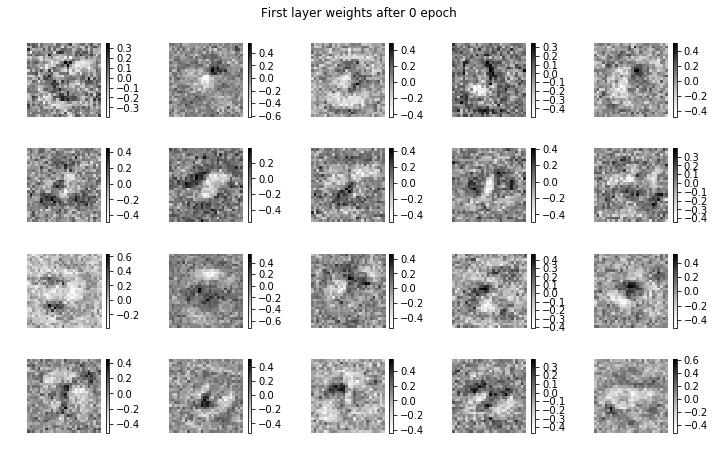

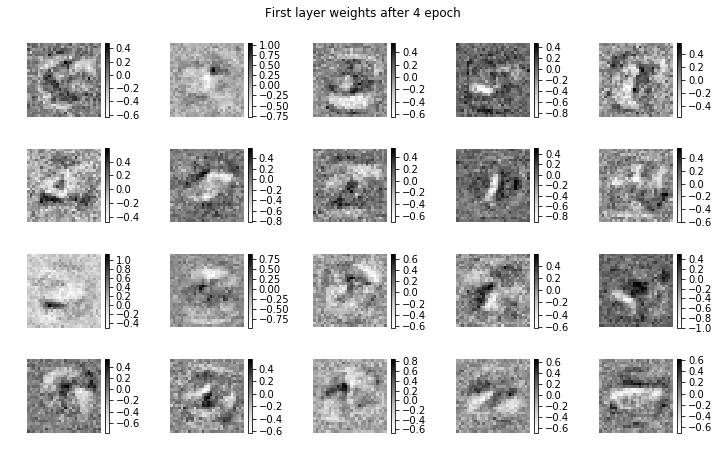

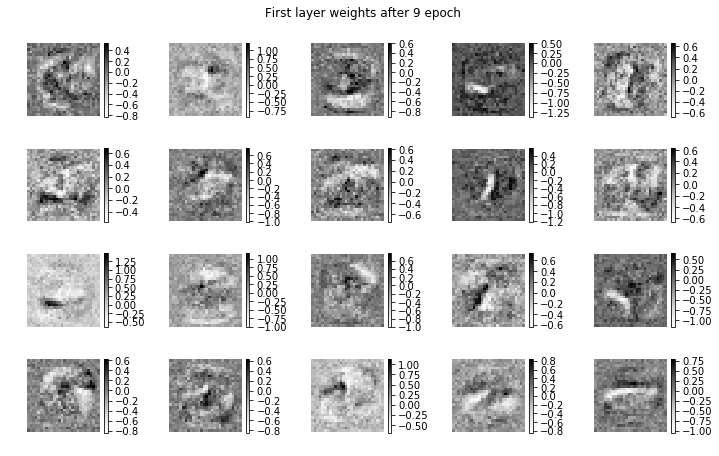

In [22]:
# Plot the weights of the first layer for the best model 
for e in [1,5,10]:
    V = Vs[0][e]
    plt.figure(figsize=(10,6))
    plt.suptitle(f'First layer weights after {e-1} epoch', y = 1.05)
    plot_digits(V.T, num_cols=5)

Logistic regression has one weight matrix per class which tries to capture the characteristics of the digit. MLP, on the other hand, has 20 weight matrices that get combined to classify a digit. This way they can capture features of the digits more granular. Features that are shared between multiple digits can be captured accurately and due to the linear combination of these features MLP can distinguish similar digits better and achieves better performance.

### 2.3.2. Different activation functions (10 points)
In the task above we use a sigmoid as an activation function.
Two other popular choices for activation functions are tanh and the rectified linear unit (ReLU). The ReLU is defined as:

$$f(x) = \max(0.,x)$$

You already derived the derivative of the softmax function above. Here, write down the derivative for both the tanh and the ReLU function. Furthermore, for all three, plot the function and its derivative in a range $x\in[-3,3]$

Write down the derivative of ReLU and tanh w.r.t. their respective argument:

Derivative of ReLu:
\begin{align*}
f(x) = max(0,x) &=  \begin{cases} 0 \quad if \quad x < 0 \\
                                      x \quad if \quad x > 0 \end{cases}\\
\frac{df(x)}{dx} &= \begin{cases} \frac{d(0)}{dx} \quad if \quad x < 0 \\
                                  \frac{d(x)}{dx} \quad if \quad x > 0 \end{cases}\\
&= \begin{cases} 0 \quad if \quad x \leq 0 \\
                 1 \quad if \quad x > 0 \end{cases}\\
\end{align*}
Derivavite of tanh:
\begin{align*}
\tanh{(x)} &= \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}} \\
\frac{d}{{dx}}\tanh (x)  &= \frac{(e^{x} + e^{-x})(e^{x} + e^{-x}) -(e^{x} - e^{-x})(e^{x} - e^{-x})}{(e^{x} + e^{-x})^2} \\
&= 1 - \tanh ^2 (x) \\
\end{align*}

Name two properties that you would like your activation function to have (one sentence each). Why are they important? 

1- The activation function has to be coninuously derivable everywhere. That is important because we need the derivatives for the SGD optimization. 

2- The activation function has to be not linear. Otherwise the neuro-net is just a sequence of matrix multiplications, which is as good having one single layer. The non-linearity of the activation function is also important for the model solve non-linear problems.


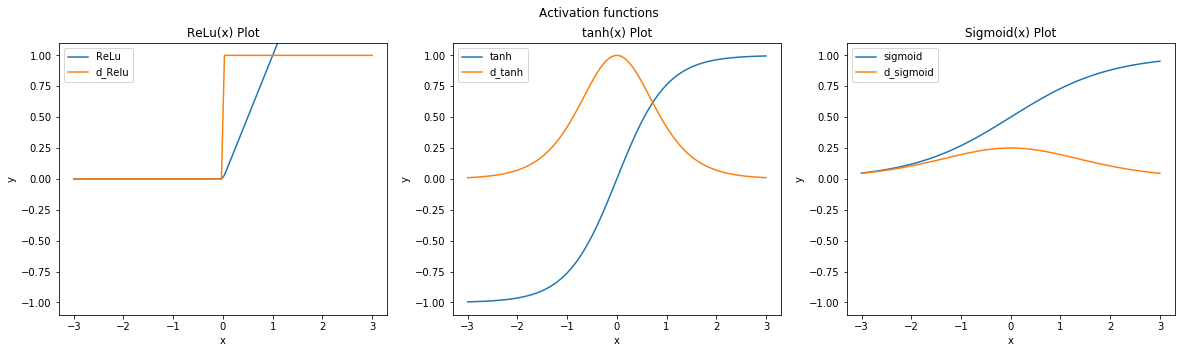

In [23]:
# plot the function and the derivative for the activations sigmoid, tanh and ReLU.
import numpy as np
from scipy.special import expit
n = 100
xs = np.linspace(-3, 3, n)
ReLu = np.maximum(xs,0)
d_ReLu = np.concatenate((np.zeros(int(n/2)), np.ones(int(n/2))))

tanh = np.tanh(xs)
d_tanh = 1- tanh**2

sig = expit(xs)
d_sig = sig*(1- sig)

plt.figure(figsize=(20,5))
# plot ReLu:
plt.subplot(1,3, 1)
plt.plot(xs, ReLu, label = 'ReLu')
plt.plot(xs, d_ReLu, label = 'd_Relu')
plt.xlabel('x')
plt.ylabel('y')
plt.title("ReLu(x) Plot")
plt.ylim(-1.1, 1.1)
plt.legend()

# plot tanh:
plt.subplot(1,3,2)
plt.plot(xs, tanh, label = 'tanh')
plt.plot(xs, d_tanh, label = 'd_tanh')
plt.xlabel('x')
plt.ylabel('y')
plt.title("tanh(x) Plot")
plt.ylim(-1.1, 1.1)
plt.legend()

# plot sigmoid:
plt.subplot(1,3,3)
plt.plot(xs, sig, label = 'sigmoid')
plt.plot(xs, d_sig, label = 'd_sigmoid')
plt.xlabel('x')
plt.ylabel('y')
plt.title("Sigmoid(x) Plot")
plt.ylim(-1.1, 1.1)
plt.legend()
    
plt.suptitle('Activation functions')
plt.show()

Now that you plotted the activations and derivatives, which activation do you think is the best? Why would you choose this activation function? For your answer consider what you named as essential properties for an activation function above. Keep your answer short at no more then 3 sentences.

Tanh seems to have nicer properties, its derivative is continuous in the whole line and it's value is 1 around the zero. ReLu has non-continuous derivative, which may lead to instability. 

In [24]:
print('Notebook ran in {:2.3} minutes.'.format((time.time()-start)/60))

Notebook ran in 6.0 minutes.
